In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
data_path = './3rd-ml100marathon-midterm/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')
print(df_train.shape)
print(df_test.shape)

(113, 22)
(33, 21)


In [3]:
# 重組資料成為訓練 / 預測用格式

# poi 這個 column 是只有 train set 才有的 (label)
train_Y = df_train['poi'].values
df_train = df_train.drop(['poi'] , axis=1) #將 column = 'poi' drop 出來
train_num = df_train.shape[0]

df = pd.concat([df_train, df_test])
df = df.drop(['name'], axis=1)
print(df.shape)
df.head(10)

(146, 20)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
5,NaN,10259.0,NaN,NaN,joe.hirko@enron.com,30766064.0,77978.0,NaN,NaN,NaN,NaN,NaN,2856.0,NaN,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,NaN,NaN,NaN,147950.0,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
7,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,11.0,NaN,NaN,101740.0,698242.0,NaN,288542.0,1132.0,1758.0,1490344.0,698242.0
8,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,3600000.0,10359729.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,600000.0,NaN,NaN,NaN,ben.glisan@enron.com,384728.0,125978.0,16.0,52.0,6.0,NaN,71023.0,200308.0,393818.0,NaN,274975.0,874.0,873.0,1272284.0,778546.0


### 處理異常欄位
* 有太多Nan的欄位，整欄不使用

In [4]:
print(df.columns)
ratio = 0.4
selected_columns = [] #只留下 非 NaN 值比率大於 ratio 的 columns 
for col in df.columns:
    if (((~df_train[col].isnull()).values.sum())/df.shape[0] > ratio):
        selected_columns.append(col)
print(selected_columns)
df = df[selected_columns]

Index(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'other', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')
['bonus', 'email_address', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']


In [5]:
#確定只有 int64, float64, object 三種類型後, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

0 Integer Features : []

13 Float Features : ['bonus', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

1 Object Features : ['email_address']


### Category Encoding

In [6]:
#name 是key 所以不處理
#對 email_address 做 LabelEncoder

df['email_address'] = df['email_address'].fillna('None')
df['email_address'] = LabelEncoder().fit_transform(df['email_address'])

In [7]:
df.head(10)

,bonus,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,56,19794175.0,46950.0,18.0,42.0,4.0,174839.0,2748364.0,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,36,19250000.0,29336.0,108.0,88.0,30.0,22122.0,6843672.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,83,1624396.0,22884.0,39.0,13.0,14.0,1573324.0,869220.0,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,73,NaN,118134.0,NaN,NaN,NaN,907502.0,985032.0,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,10,NaN,35818.0,144.0,199.0,25.0,486.0,126027.0,240189.0,2188.0,2598.0,1639297.0,126027.0
5,NaN,45,30766064.0,77978.0,NaN,NaN,NaN,2856.0,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,NaN,98,8308552.0,53947.0,NaN,NaN,NaN,147950.0,3576206.0,158403.0,NaN,NaN,360300.0,11884758.0
7,1200000.0,111,NaN,16514.0,40.0,240.0,11.0,101740.0,698242.0,288542.0,1132.0,1758.0,1490344.0,698242.0
8,7000000.0,57,34348384.0,99832.0,36.0,123.0,16.0,10359729.0,14761694.0,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,600000.0,4,384728.0,125978.0,16.0,52.0,6.0,200308.0,393818.0,274975.0,874.0,873.0,1272284.0,778546.0


### 觀察每個 Float 欄位的分佈

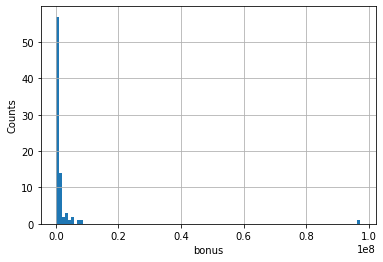

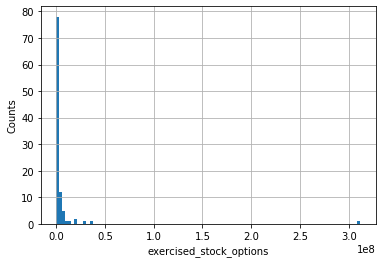

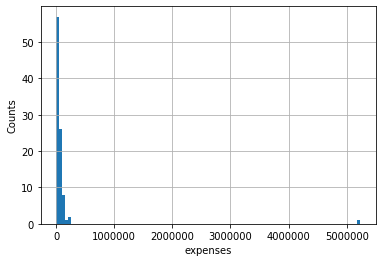

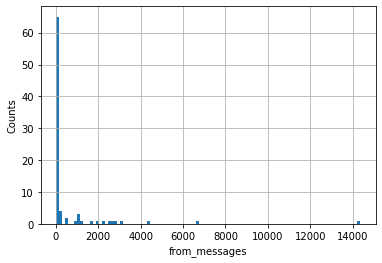

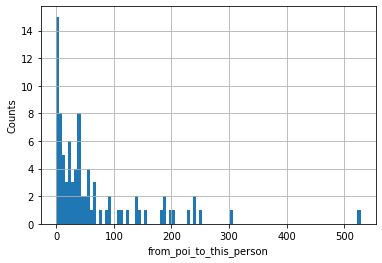

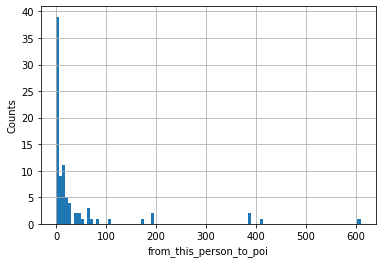

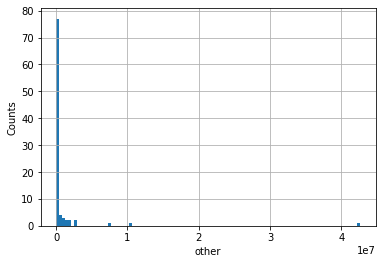

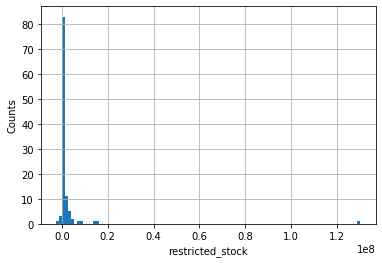

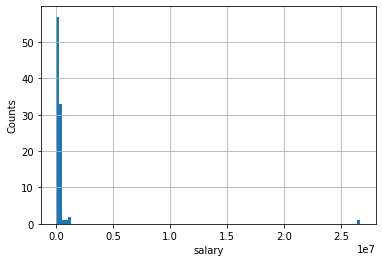

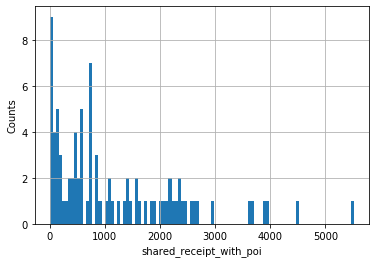

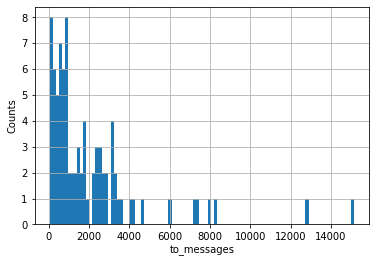

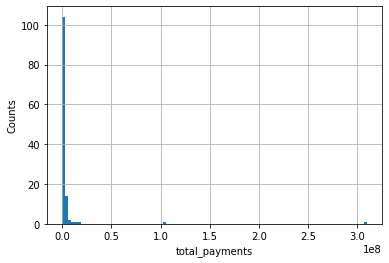

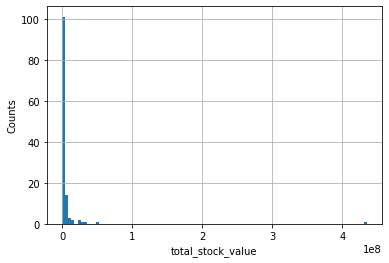

In [8]:
#畫出每個 Float Feature 的分布

ncols = 1;
nrows = len(float_features)
ind = 0
for f in float_features:
    plt.figure(num=ind)
    ind += 1
    s_tmp = df[f][(~df[f].isnull())] #拿非NaN 的來算統計    
    s_tmp.hist(bins = 100)
    plt.ylabel('Counts')
    plt.xlabel(f)
plt.show() 

### 處理 Outlier

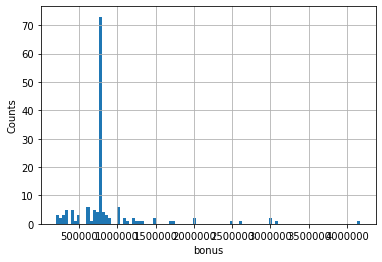

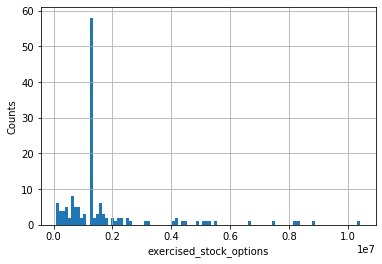

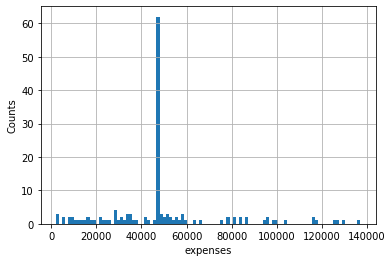

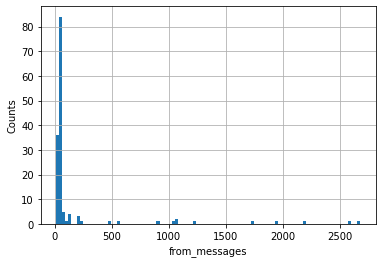

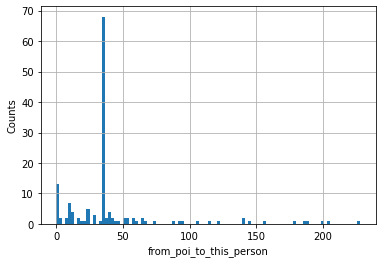

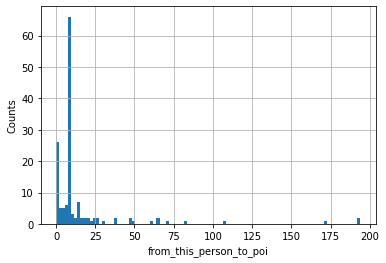

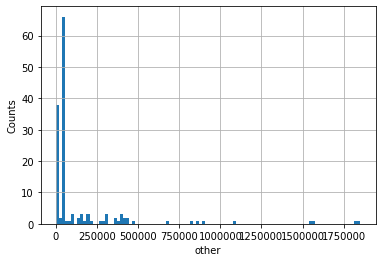

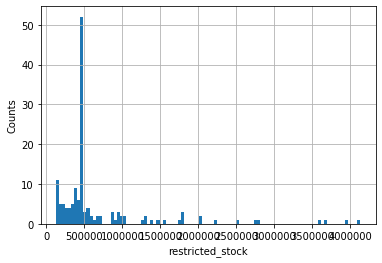

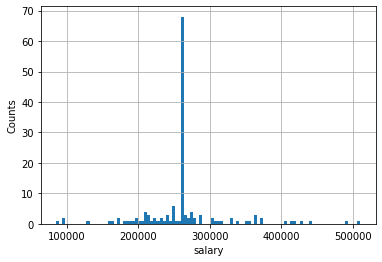

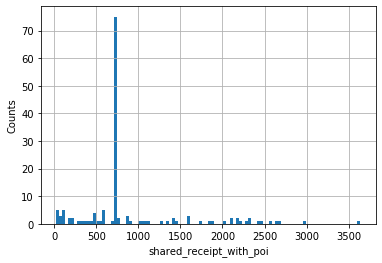

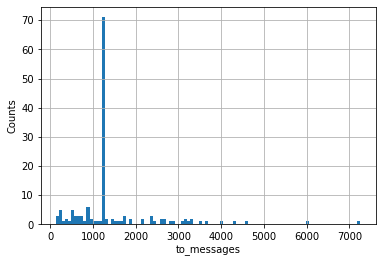

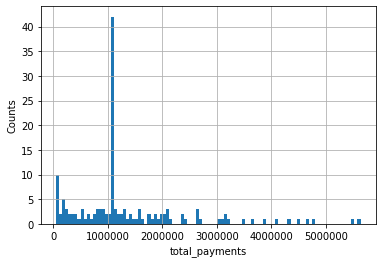

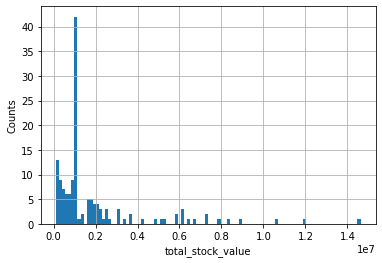

In [9]:
#對於每個 Float Feature 的分布，去除篇移值(用中位數替代)

ncols = 1;
nrows = len(float_features)
ind = 0
for f in float_features:
    plt.figure(num=ind)
    ind += 1
    s_tmp = df[f][(~df[f].isnull())] #拿非NaN 的來算統計
    md = s_tmp.median()
    new_series = df[f].copy()
    new_series[df[f].isnull()] = md #nan 值用中位數取代
    
    thr_u = s_tmp.quantile(0.95) #upper 
    thr_l = s_tmp.quantile(0.05) #lower
    new_series[new_series>thr_u] = md 
    new_series[new_series<thr_l] = md
    
    new_series.hist(bins = 100)
    plt.ylabel('Counts')
    plt.xlabel(f)
    
    df[f] = new_series #將處理後的 Series 塞回去原本的 DataFrame
plt.show() 

In [10]:
df.head(10)

,bonus,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,56,1310813.5,46950.0,18.0,42.0,4.0,174839.0,2748364.0,420636.0,864.0,905.0,505050.0,1102872.5
1,769375.0,36,1310813.5,29336.0,108.0,88.0,30.0,22122.0,451740.0,259996.0,2042.0,3627.0,1101393.0,1102872.5
2,200000.0,83,1624396.0,22884.0,39.0,13.0,14.0,1573324.0,869220.0,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,73,1310813.5,118134.0,41.0,35.0,8.0,907502.0,985032.0,224305.0,740.5,1211.0,2652612.0,985032.0
4,1250000.0,10,1310813.5,35818.0,144.0,199.0,25.0,486.0,126027.0,240189.0,2188.0,2598.0,1639297.0,126027.0
5,769375.0,45,1310813.5,77978.0,41.0,35.0,8.0,2856.0,451740.0,259996.0,740.5,1211.0,91093.0,1102872.5
6,769375.0,98,8308552.0,53947.0,41.0,35.0,8.0,147950.0,3576206.0,158403.0,740.5,1211.0,360300.0,11884758.0
7,1200000.0,111,1310813.5,16514.0,40.0,35.0,11.0,101740.0,698242.0,288542.0,1132.0,1758.0,1490344.0,698242.0
8,769375.0,57,1310813.5,99832.0,36.0,123.0,16.0,52382.0,451740.0,259996.0,2411.0,4273.0,1101393.0,1102872.5
9,600000.0,4,384728.0,125978.0,16.0,52.0,6.0,200308.0,393818.0,274975.0,874.0,873.0,1272284.0,778546.0


### Traning  (baseline)
* Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [14]:
train_X = df[:train_num].values
# estimator = LogisticRegression(solver='lbfgs') #有紅字 0.8225
# estimator = LogisticRegression(solver='newton-cg') #0.8225
estimator = LogisticRegression(solver='liblinear') #0.7877
# estimator = LogisticRegression(solver='sag') #0.8671
# estimator = LogisticRegression(solver='saga')  #0.8671

print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

0.7877470355731224


In [59]:
# 13 = 3 + 3 + 3 + 4  (positive)
# 100 = 25 + 25 + 25 + 25 (negative)
# 建立 indicate set

ind_1 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(3):
    ind_1[i] = True;
for i in range(start_ind, start_ind+25):
    ind_1[i] = True
    
ind_2 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(3, 6):
    ind_2[i] = True;
for i in range(start_ind+25, start_ind+50):
    ind_2[i] = True;
    
ind_3 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(6, 9):
    ind_3[i] = True;
for i in range(start_ind+50, start_ind+75):
    ind_3[i] = True;

ind_4 = np.zeros((113), dtype=bool)
start_ind = 13 #開始 negative
for i in range(9, 13):
    ind_4[i] = True;
for i in range(start_ind+75, start_ind+100):
    ind_4[i] = True;

i=0 
 [ True  True  True False False False False False False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
i=1 
 [False False False  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True 

In [ ]:
for i in range(len(indices)):
    print('i=%d \n'%i, indices[i])

In [78]:
log_reg  = LogisticRegression(solver='saga')

# 訓練模型
train_ind = ~ind_1
test_ind = ind_1
log_reg.fit(train_X[train_ind], train_Y[train_ind])

# x_test = df[test_ind] #取 df 後半段為 test
print(test_ind.shape)
# # 預測測試集
# #注意 logistic regression 的預測輸出，第一個column 是 0 的機率，第二個 column 是 1 的機率
# y_pred_prob = log_reg.predict_proba(x_test)[:,1] 

(113,)


c:\users\raoblack\documents\python_env\100ai\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### 建立Kaggle submission

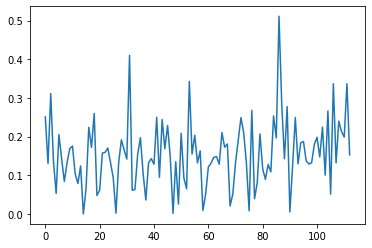

In [16]:
pr = log_reg.predict_proba(train_X)[:, 1]

plt.figure()
plt.plot(pr)
plt.show()

In [ ]:
test_tmp = pd.read_csv(data_path + 'test_features.csv')
submission_df = pd.DataFrame()
submission_df['name'] = test_tmp['name']
submission_df['poi'] = y_pred_prob
print(submission_df)

In [ ]:
submission_df.to_csv('Result.csv', index=False)

In [ ]:
df_sample_submission = pd.read_csv(data_path + 'sample_submission.csv')
print(df_sample_submission)